In [1]:
from fastai.vision import *

# Classification of Bonnet and Rhesus Macaque
### Inspired from the monkeys of IIT-Madras (Macaca radiata)

## URLs from gi2ds

### method used - source: https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md

In [3]:
folder = 'bonnet'
file = 'bonnet_macaque.txt'

In [4]:
path = Path('data/monkeys')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[WindowsPath('data/monkeys/bonnet'),
 WindowsPath('data/monkeys/cleaned.csv'),
 WindowsPath('data/monkeys/japanese'),
 WindowsPath('data/monkeys/models'),
 WindowsPath('data/monkeys/rhesus'),
 WindowsPath('data/monkeys/taiwanese')]

### Downloading images from url saved in .txt file

In [ ]:
download_images(path/folder/file, dest, max_pics=300,max_workers=0)

In [ ]:
folder1 = 'rhesus'
file = 'rhesus_macaque.txt'
path1 = Path('data/monkeys')
dest1 = path1/folder1
dest1.mkdir(parents=True, exist_ok=True)
path1.ls()

In [ ]:
download_images(path1/folder1/file, dest1, max_pics=300,max_workers=0)

In [ ]:
folder2 = 'japanese'
file = 'japanese_macaque.txt'
path2 = Path('data/monkeys')
dest2 = path2/folder2
dest2.mkdir(parents=True, exist_ok=True)
path2.ls()

In [ ]:
download_images(path2/folder2/file, dest2, max_pics=300,max_workers=0)

In [ ]:
folder3 = 'taiwanese'
file = 'taiwan_macaque.txt'
path3 = Path('data/monkeys')
dest3 = path3/folder3
dest3.mkdir(parents=True, exist_ok=True)
path3.ls()

In [ ]:
download_images(path3/folder3/file, dest3, max_pics=300,max_workers=0)

In [5]:
classes = ['bonnet','rhesus','japanese','taiwanese']

### Cleaning the images

In [6]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True,max_workers=8, max_size=1300)

bonnet


rhesus


japanese


taiwanese


In [7]:
import numpy as np
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=0).normalize(imagenet_stats)

In [8]:
data.classes

['bonnet', 'japanese', 'rhesus', 'taiwanese']

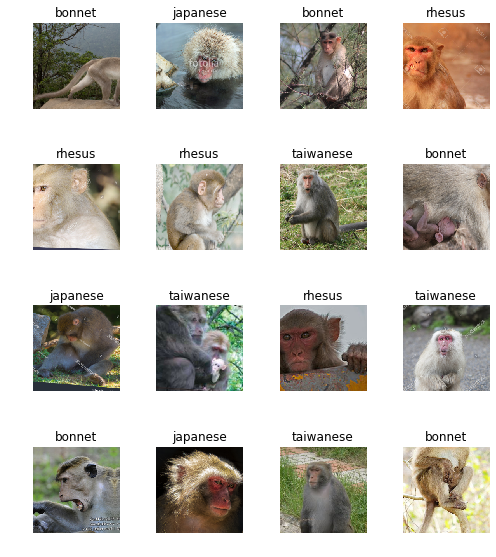

In [9]:
data.show_batch(rows=4, figsize=(7,8))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bonnet', 'japanese', 'rhesus', 'taiwanese'], 4, 902, 225)

## Training the Model using Resnet34

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.404935,0.674902,0.733333,02:37
1,1.029095,0.574659,0.800000,02:08
2,0.858920,0.567278,0.795556,02:03
3,0.746297,0.562609,0.800000,02:02


In [13]:
learn.save('stage-1')

In [14]:
learn.unfreeze()

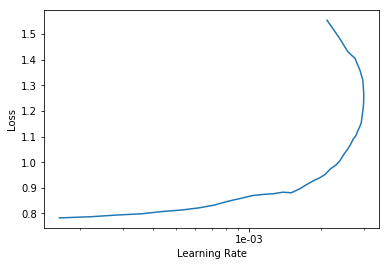

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.522398,0.509827,0.844444,02:07
1,0.437949,0.523527,0.813333,02:19


In [17]:
learn.save('stage-2')

## Interpretation of Results

In [18]:
learn.load('stage-2');

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

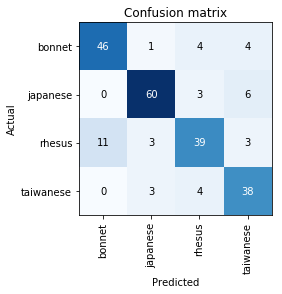

In [20]:
interp.plot_confusion_matrix()

### From the above confusion matrix we can say

* The learning model got most confused with rhesus and bonnet - which is acceptable since they visually very similar and even for a human distinguishing them apart is hard

* of all the species, the Japanese Macaque is the most visually distinct considering it has the highest no of matching values



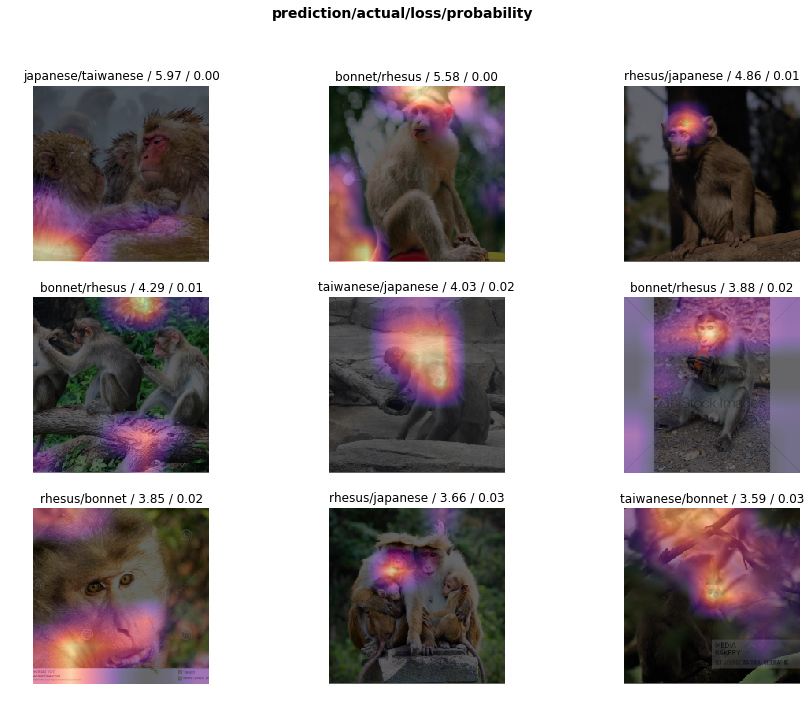

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
interp.most_confused(min_val=2)

[('rhesus', 'bonnet', 11),
 ('japanese', 'taiwanese', 6),
 ('bonnet', 'rhesus', 4),
 ('bonnet', 'taiwanese', 4),
 ('taiwanese', 'rhesus', 4),
 ('japanese', 'rhesus', 3),
 ('rhesus', 'japanese', 3),
 ('rhesus', 'taiwanese', 3),
 ('taiwanese', 'japanese', 3)]

## Cleaning up 

### Removing top inducing images 

In [23]:
from fastai.widgets import *

In [24]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch(num_workers = 0)
     )

In [25]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [26]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln,num_workers = 0)

In [27]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [28]:
bs = 4
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                 .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch(num_workers=0)
      )

In [29]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

## Predicting

In [32]:
learn_cln.export()

In [33]:
defaults.device = torch.device('cpu')

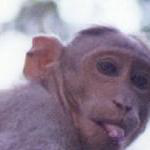

In [34]:
img = open_image(path/'test.jpg')
img

In [35]:
learn_cln = load_learner(path)
import torch
torch.cuda.empty_cache()

In [41]:
pred_class,pred_idx,outputs = learn_cln.predict(img)
pred_class

Category bonnet